In [1]:
from neo4j.v1 import GraphDatabase
from neo4j.v1 import Node 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
uri = "bolt://neo4j:7687"
graph = GraphDatabase.driver(uri)

# Number of articles found

In [3]:
#count the number of DISTINCT titles found in the graphDB
def get_article_count(tx):
    count = 0
    for record in tx.run("MATCH (a:Article) RETURN true"):
        count += 1
    return count

In [4]:
with graph.session() as session:
    article_count = session.read_transaction(get_article_count)
print("Number of articles: ", article_count)

Number of articles:  1872692


# Author that has published most articles

In [5]:
#find the most connected author node
#group by the size of the author list and return the largest one
def get_most_popular_author(tx):
    for record in tx.run("MATCH (a)-[r]->(b) RETURN a, COLLECT(a) as author ORDER BY SIZE(author) DESC LIMIT 1"):
        return (record['author'][0]['name'])    

In [6]:
with graph.session() as session:
    most_popular = session.read_transaction(get_most_popular_author)
print("Author that has published the most articles: ", most_popular)

TransientError: There is not enough memory to perform the current task. Please try increasing 'dbms.memory.heap.max_size' in the neo4j configuration (normally in 'conf/neo4j.conf' or, if you you are using Neo4j Desktop, found through the user interface) or if you are running an embedded installation increase the heap by using '-Xmx' command line flag, and then restart the database.

# Visualisation of Authorship Subgraph

In [7]:
cs_members = ['Gordon J. Pace', 'Keith Bugeja', 'Christian Colombo', 'Adrian Francalanza', 'Mark Micallef', 'Sandro Spina', 'Kevin Vella']

In [8]:
def get_authorship(tx, author_name, authorship_df):
    title_list = []
    query = "MATCH (a:Author {name: $author_name})-[r:PUBLISH]-(b:Article) RETURN b.title"
    for record in tx.run(query, author_name = author_name):
        authorship_df = authorship_df.append([[author_name, record[0]]])
    return authorship_df

authorship_df = pd.DataFrame()
with graph.session() as session:
    for author_name in cs_members:
        authorship_df = session.read_transaction(get_authorship, author_name, authorship_df)

authorship_df.columns = ['Author','Article']
authorship_df = authorship_df.reset_index().drop(columns=['index'])
authorship_df

,Author,Article
0,Gordon J. Pace,Algorithmic analysis of polygonal hybrid syste...
1,Gordon J. Pace,Distributed system contract monitoring.
2,Gordon J. Pace,Guest Editors' Foreword.
3,Gordon J. Pace,Monitor-Oriented Compensation Programming Thro...
4,Gordon J. Pace,Counter-example generation in symbolic abstrac...
5,Gordon J. Pace,A Survey of Challenges for Runtime Verificatio...
6,Gordon J. Pace,Explaining Violation Traces with Finite State ...
7,Gordon J. Pace,Recovery within long-running transactions.
8,Gordon J. Pace,An embedded language approach to teaching hard...
9,Gordon J. Pace,On the Specification of Full Contracts.


# Shortest Path Between 2 Authors

In [9]:
def find_shortest_path(tx, author1_name, author2_name):
    query = "MATCH (a1:Author { name: $author1_name }), (a2:Author { name: $author2_name}), p = shortestPath((a1)-[*]-(a2)) WHERE length(p) > 1 return EXTRACT (n in nodes(p) | n.name) as nodes_on_path" 
    result = tx.run(query, author1_name=author1_name, author2_name=author2_name)
    for record in result:
        print("A path exists and it is ", list(filter(lambda x: x!=None, record[0]))) #drop none values (Author nodes)
    return result

In [10]:
with graph.session() as session:
    path = session.read_transaction(find_shortest_path, 'Jean-Paul Ebejer', 'Donald E. Knuth')

A path exists and it is  ['Jean-Paul Ebejer', 'Paul W. Finn', 'Rajeev Motwani', 'Donald E. Knuth']


# Erdos Number of a researcher

In [11]:
#Paul Erdős's Erdős number is zero. 
#Those who have written a paper with him have an Erdős number of one
#those who write a paper with someone with an Erdős number one but who haven't collaborated with Erdős directly, have an Erdős number of two.

In [12]:
def get_erdos_number(tx, author_name):
    erdos_num = 0
    query = "MATCH (a1:Author {name: $author_name}), (a2:Author {name: 'Paul Erdös'}), p = shortestPath((a1)-[r*]-(a2)) WHERE length(p) > 1 return EXTRACT (n in nodes(p) | n.name) as nodes_on_path"
    result = tx.run(query, author_name=author_name)   
    for record in result:
        #first author linked to Erdos has erdos number 1
        erdos_num = len(list(filter(lambda x: x!=None, record[0]))) - 1 #drop none values (Author nodes)
        print("The Erdos Number of ", author_name, ' is ', erdos_num) 
    return erdos_num

In [13]:
with graph.session() as session:
    shortest_path = session.read_transaction(find_shortest_path, 'Jean-Paul Ebejer', 'Paul Erdös')
    result = session.read_transaction(get_erdos_number, 'Jean-Paul Ebejer')

A path exists and it is  ['Jean-Paul Ebejer', 'Charlotte M. Deane', 'Graham R. Wood', 'Jenö Lehel', 'Paul Erdös']
The Erdos Number of  Jean-Paul Ebejer  is  4


# Erdos num for all members in faculty

In [14]:
ict_members = ['Gordon J. Pace','Keith Bugeja','Christian Colombo','Adrian Francalanza','Mark Micallef','Sandro Spina','Kevin Vella','Carl J. Debono','Adrian Muscat','Reuben A. Farrugia','Trevor Spiteri','John Abela','Christopher P. Porter','Alexiei Dingli','Matthew Montebello','Michael Rosner','Claudia Borg','Edward Gatt','Owen Casha','Ivan Grech','Johann A. Briffa','Victor Buttigieg','Saviour Zammit','Joel Azzopardi','Christopher Staff','George Azzopardi','Joseph Micallef']
erdos_list = []
with graph.session() as session:
    for author in ict_members:
        erdos_list.append(session.read_transaction(get_erdos_number, author))

The Erdos Number of  Gordon J. Pace  is  2
The Erdos Number of  Keith Bugeja  is  4
The Erdos Number of  Christian Colombo  is  3
The Erdos Number of  Adrian Francalanza  is  3
The Erdos Number of  Mark Micallef  is  4
The Erdos Number of  Sandro Spina  is  4
The Erdos Number of  Kevin Vella  is  4
The Erdos Number of  Carl J. Debono  is  5
The Erdos Number of  Adrian Muscat  is  3
The Erdos Number of  Reuben A. Farrugia  is  3
The Erdos Number of  Trevor Spiteri  is  3
The Erdos Number of  John Abela  is  3
The Erdos Number of  Christopher P. Porter  is  3
The Erdos Number of  Alexiei Dingli  is  3
The Erdos Number of  Matthew Montebello  is  4
The Erdos Number of  Michael Rosner  is  3
The Erdos Number of  Claudia Borg  is  3
The Erdos Number of  Edward Gatt  is  5
The Erdos Number of  Owen Casha  is  4
The Erdos Number of  Ivan Grech  is  4
The Erdos Number of  Johann A. Briffa  is  3
The Erdos Number of  Victor Buttigieg  is  4
The Erdos Number of  George Azzopardi  is  3
The Erdos

Text(0.5,1,'Erdos Number for members of the Faculty of ICT')

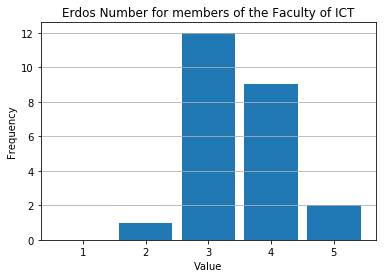

In [15]:
plt.hist(x=erdos_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], rwidth=0.85)
plt.grid(axis='y')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Erdos Number for members of the Faculty of ICT')